## Cross-species conservation of motifs

I should write a nice summary and introduction here.

In [1]:
# import everything
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import zscore

import util

In [2]:
# make sure to work with the correct assemblies
if 'snakemake' in globals():
    assemblies = snakemake.params
else:
    import glob
    assemblies = [assembly.split("/")[1] for assembly in glob.glob("gimme_smooth/**/activity.bayesianridge.score.out.txt")]

print(assemblies)
    
# load the assemblies as dataframes
dfs = dict()
for assembly in assemblies: 
    dfs[assembly] = pd.read_csv(f"gimme_smooth/{assembly}/activity.bayesianridge.score.out.txt", sep="\t", comment="#", index_col=0)

['ASM318616v1', 'Bl71nemr', 'xenTro9', 'ASM223467v1', 'mm10', 'danRer11', 'GRCg6a', 'Astyanax_mexicanus-2.0']


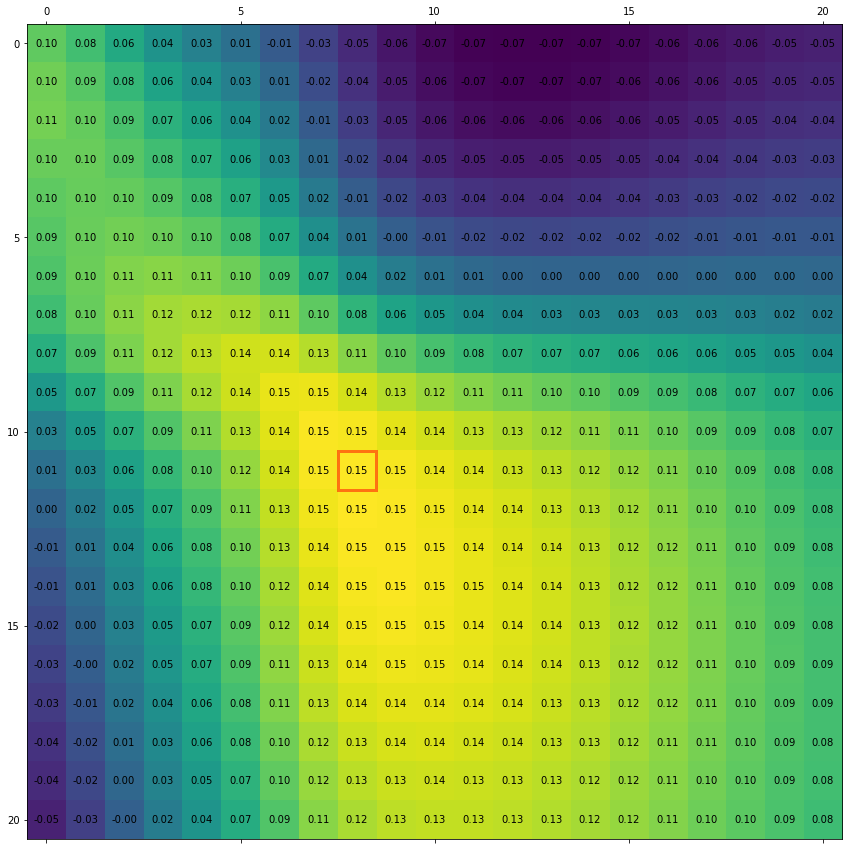

In [5]:
fix, ax = plt.subplots(figsize=(15,15))

df1 = dfs["Bl71nemr"]
df2 = dfs["ASM318616v1"]
corr = pd.concat([df1, df2], axis=1, keys=['df1', 'df2']).corr().loc['df2', 'df1'].T
*outline, _ = util.get_outline(corr.values)
ax.plot(*outline, color=(1,0,0,.5), linewidth=3)
ax.matshow(corr.values)
for (i, j), z in np.ndenumerate(corr.values):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

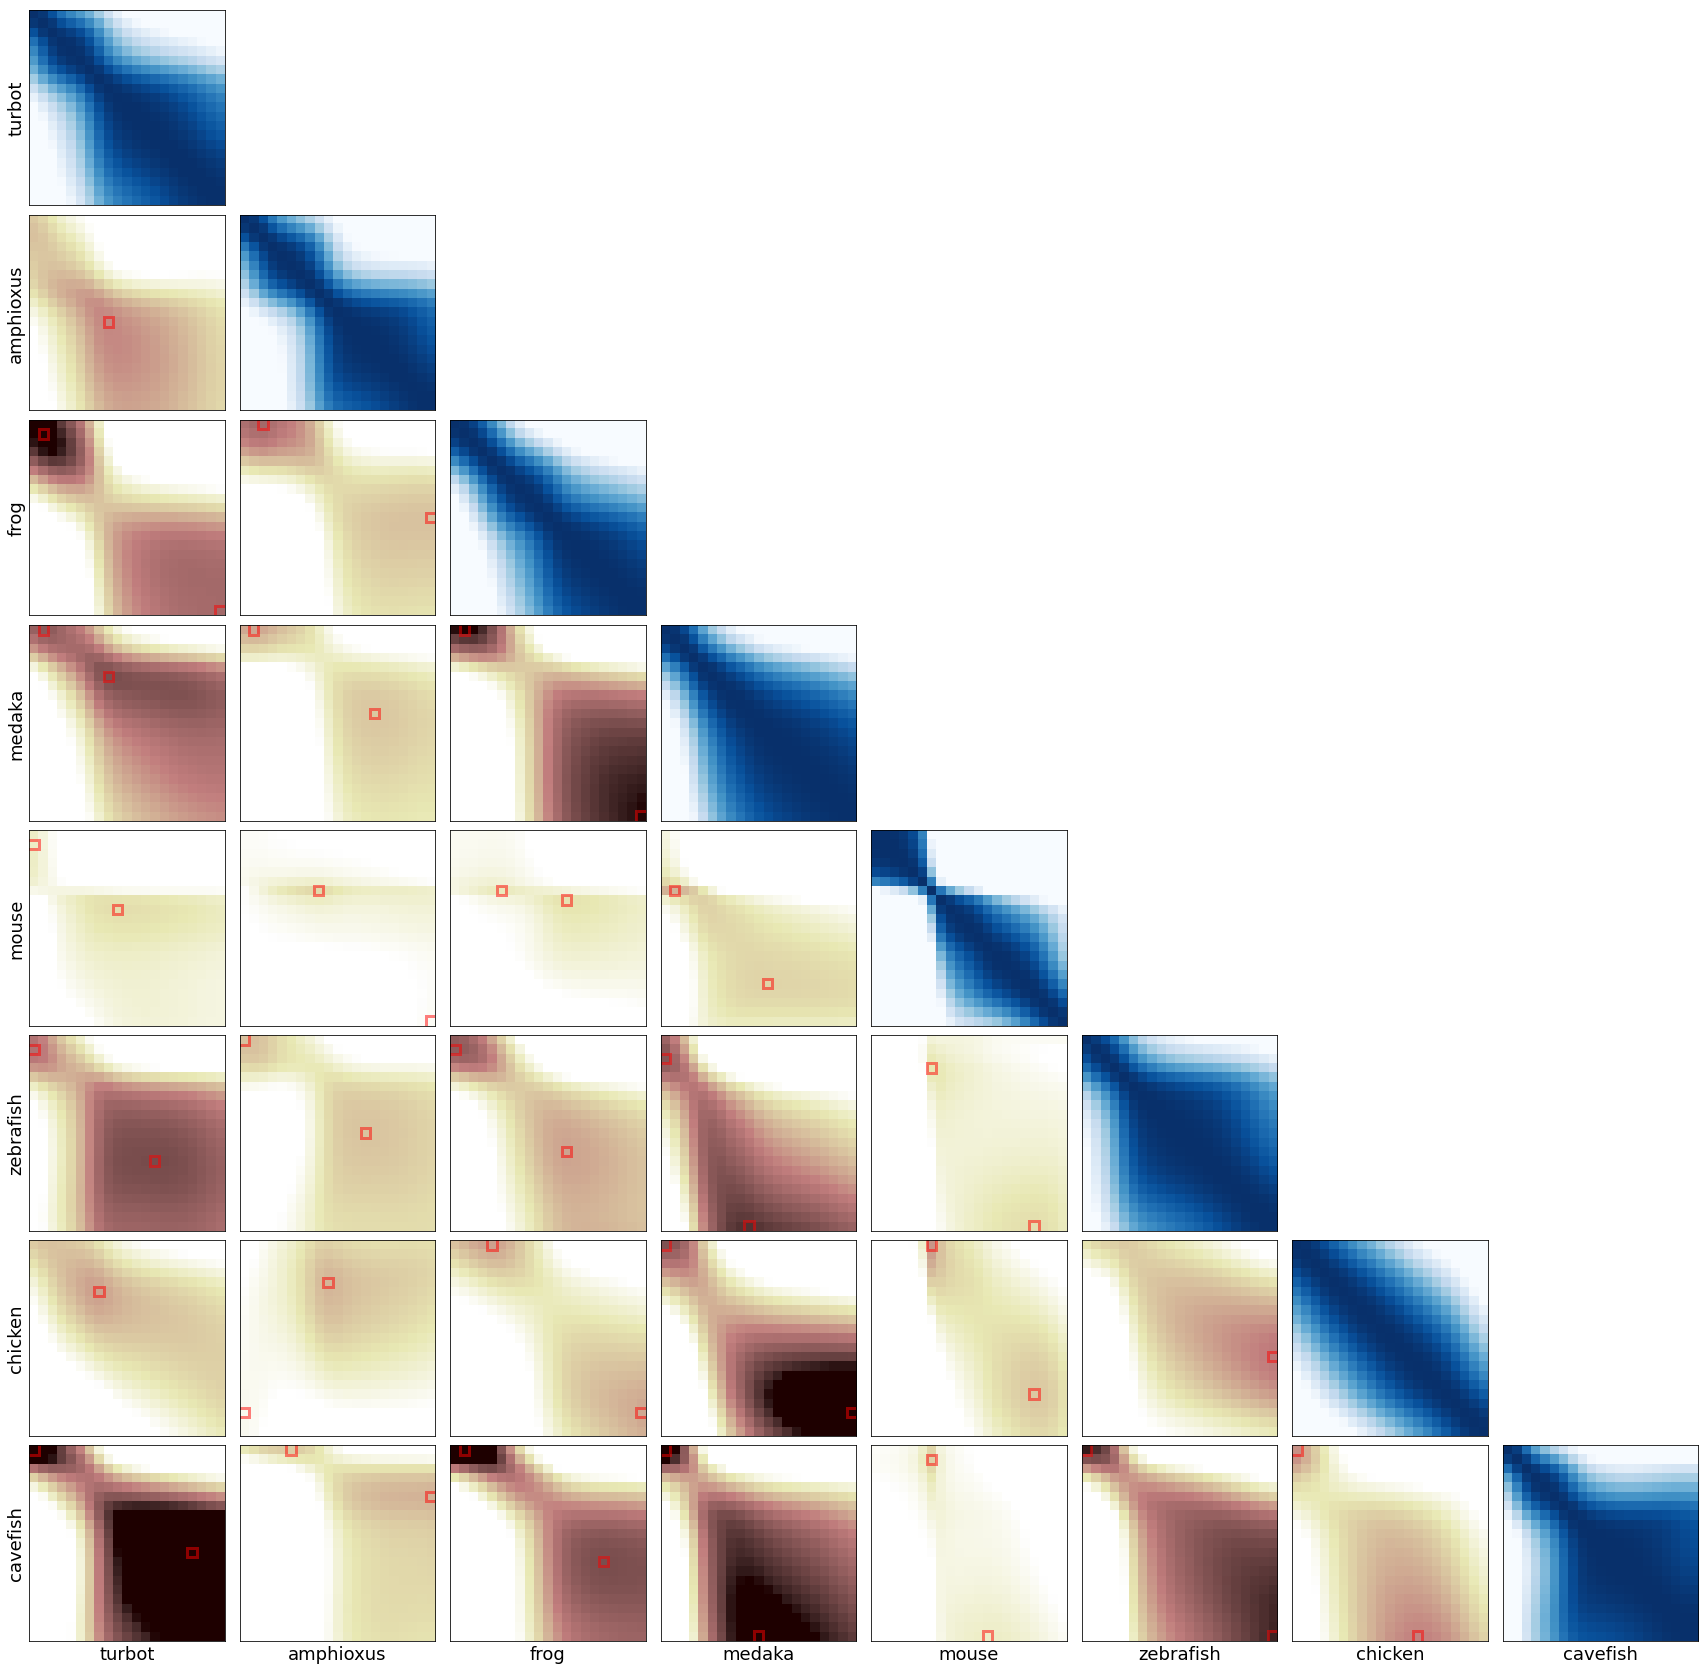

In [4]:
nr_assemblies = len(dfs.keys())

fig, axes = plt.subplots(figsize=(30, 30), nrows=len(dfs.keys()), ncols=len(dfs.keys()))
# fig, axes = plt.subplots(figsize=(15, 15), nrows=len(dfs.keys()), ncols=len(dfs.keys()))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)

early = pd.DataFrame(index=dfs["danRer11"].index)
late = pd.DataFrame(index=dfs["danRer11"].index)

def get_bars(assembly):
    bars = dict()
    for phase, color in colors.items():
        start = timings.loc[assembly, phase]
        col_idx = list(timings.columns).index(phase)
        if col_idx != -1:
            for end_col in timings.columns[col_idx + 1:]:
                end = timings.loc[assembly, end_col]
                if not np.isnan(end):
                    bars[phase] = (start, end, color)
                    break
    return bars

for assembly_1_i, assembly_1 in enumerate(dfs.keys()):
    for assembly_2_i, assembly_2 in enumerate(dfs.keys()):
        ax = axes[assembly_1_i, assembly_2_i]

        if assembly_2_i > assembly_1_i: 
            ax.axis('off')
            continue
        df1 = dfs[assembly_1]
        df2 = dfs[assembly_2]
        corr = pd.concat([df1, df2], axis=1, keys=['df1', 'df2']).corr().loc['df2', 'df1'].T

        if assembly_1 == assembly_2:
            vmin, vmax = 0, 1
            cmap = "Blues"
        else:
            vmin, vmax = 0, 0.25
            cmap = "pink_r"
                
        im = ax.matshow(corr.values, aspect=len(df2.columns)/len(df1.columns), vmin=vmin, vmax=vmax, cmap=cmap)
        if assembly_1 != assembly_2:
            *outline, maxima = util.get_outline(corr.values)
            ax.plot(*outline, color=(1,0,0,.5), linewidth=3)
            if len(np.where(maxima)[0]) == 2:
                time_1_1, time_1_2 = np.where(maxima)[0]
                time_2_1, time_2_2 = np.where(maxima)[1]
                
                # TODO
                # z-score (not necessary with newest gimme)

                df_tmp = pd.concat([df1.iloc[:, time_1_1], df2.iloc[:, time_2_1]], axis=1)
                df_tmp[:] = zscore(df_tmp, axis=0)
                df_tmp["average"] = np.mean(df_tmp.values, axis=1)
                early[f"{assembly_1} & {assembly_2}"] = df_tmp["average"].rank(method='average')

#                 print(df1.iloc[:, time1])
#                 assert False
                
#             for (i, j), z in np.ndenumerate(corr.values):
#                 ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
        ax.set_xticks([])
        ax.set_yticks([])
        if assembly_2_i == 0:
#             ax.set_yticks(range(corr.shape[0]), minor=False)
#             ax.set_yticklabels(corr.index, fontsize=14)
            ax.set_ylabel(util.ass2name(assembly_1), fontsize=18)
            
#             for start, stop, color in get_bars(assembly_1).values():
#                 p_start = float(corr.index[0])
#                 p_stop = float(corr.index[-1])
#                 stop  = list(sorted([0, 1, (stop - p_start) / (p_stop - p_start)]))[1]
#                 start = list(sorted([0, 1, (start  - p_start) / (p_stop - p_start)]))[1]
#                 add_bar_left(im, start, stop, color=color)

        if assembly_1_i == nr_assemblies - 1:
            ax.set_xlabel(util.ass2name(assembly_2), fontsize=18)
#             for start, stop, color in get_bars(assembly_2).values():
#                 p_start = float(corr.columns[0])
#                 p_stop = float(corr.columns[-1])
#                 stop  = list(sorted([0, 1, (stop - p_start) / (p_stop - p_start)]))[1]
#                 start = list(sorted([0, 1, (start  - p_start) / (p_stop - p_start)]))[1]
#                 add_bar_lower(im, start, stop, color=color)
        
#         # pretty colorbar
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size="5%", pad=0.1)
#         plt.colorbar(im, cax=cax)

#         ax.set_aspect('equal')
# fig.colorbar(im, ax=axes[0])